In [13]:
import QuantLib as ql
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import os

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

from scipy.optimize import brentq


display(HTML("<style>.container { width:95% !important; }</style>"))
#126.0.6478.63
chrome_driver_path = r"C:\Program Files\chromedriver\chromedriver.exe"

In [14]:
# Test part with correct conventions from DMO website
trade_date = ql.Date(14, 6, 2024)
ql.Settings.instance().tradeDate = trade_date

# Bond parameters
issue_date = ql.Date(20, 5, 2020)  # Issue date
maturity_date = ql.Date(22, 10, 2061)  # Maturity date (41-year bond)
tenor = ql.Period(ql.Semiannual)  # Semiannual payments
calendar = ql.UnitedKingdom()  # UK calendar
business_convention = ql.ModifiedFollowing  # Business convention for schedule and ex-dividend
day_count = ql.ActualActual(ql.ActualActual.ISMA)  # Day count convention Actual/Actual (ISMA)
coupon_rate = 0.005  # 0.5% annual coupon rate
coupons = [coupon_rate]

# Create the schedule
schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar,
                       business_convention, business_convention,
                       ql.DateGeneration.Backward, False)

ex_dividend_days = 7  # 7 business days before the coupon date
settlement_days = 1
settlement_date = calendar.advance(trade_date, ql.Period(1, ql.Days), business_convention, False)

# Create the fixed rate bond
face_value = 1000  # Face value of the bond
fixed_rate_bond = ql.FixedRateBond(settlement_days, face_value, schedule, coupons, day_count)

# Create a flat yield term structure for discounting
spot_rate = 4.1386479 / 100  # Example 4% flat yield curve
flat_term_structure = ql.FlatForward(trade_date, ql.QuoteHandle(ql.SimpleQuote(spot_rate)), day_count)
discount_curve = ql.RelinkableYieldTermStructureHandle(flat_term_structure)

# Create a bond engine with the discount curve
bond_engine = ql.DiscountingBondEngine(discount_curve)
fixed_rate_bond.setPricingEngine(bond_engine)

# Calculate bond details
clean_price = fixed_rate_bond.cleanPrice()
dirty_price = fixed_rate_bond.dirtyPrice()
ytm = fixed_rate_bond.bondYield(day_count, ql.Compounded, ql.Semiannual)

# Initialize data storage
data = []

# Generate schedule with details
previous_date = issue_date + 1
previous_ex_div = issue_date
for payment_date in schedule:
   # if payment_date > trade_date:
        # Calculate ex-dividend date as 7 business days before the payment date
        ex_dividend_date = calendar.advance(payment_date, ql.Period(-ex_dividend_days, ql.Days), business_convention, False)
        # Adjust the ex-dividend date to ensure it is a business day

        # Calculate the number of actual days in the coupon period
        actual_days = day_count.dayCount(previous_date, payment_date)
        if settlement_date > previous_ex_div and settlement_date <= ex_dividend_date:
            days_in_cpn = day_count.dayCount(previous_date, settlement_date)
        else: 
            days_in_cpn = day_count.dayCount(previous_date, payment_date)
        
        # Calculate the coupon amount based on the Actual/Actual (ISMA) convention
        accrual = face_value * coupon_rate / 2 * days_in_cpn / actual_days

        # Convert QuantLib dates to Python datetime objects for formatting
        payment_date_str = ql.Date.to_date(payment_date).strftime('%Y-%m-%d')
        ex_dividend_date_str = ql.Date.to_date(ex_dividend_date).strftime('%Y-%m-%d')

        # Store data
        data.append({
            "Payment Date": payment_date_str,
            "Ex-Dividend Date": ex_dividend_date_str,
            "Accrual": accrual,
            "Clean Price": clean_price,
            "Dirty Price": dirty_price,
            "YTM": ytm * 100  # Convert to percentage
        })
        previous_date = payment_date  # Update previous date for the next iteration
        previous_ex_div = ex_dividend_date
# Create DataFrame
df = pd.DataFrame(data)

In [ ]:
df.to_excel('bond_details.xlsx', index=False)

In [15]:
#Set target clean price to get spor rate to paste in the code below and get dynamic of bond prices
# Target clean price
target_clean_price = 30.676

# Function to calculate the clean price for a given spot rate
def calculate_clean_price(spot_rate, trade_date, fixed_rate_bond, day_count):
    ql.Settings.instance().evaluationDate = trade_date
    flat_term_structure = ql.FlatForward(trade_date, ql.QuoteHandle(ql.SimpleQuote(spot_rate)), day_count)
    discount_curve = ql.RelinkableYieldTermStructureHandle(flat_term_structure)
    bond_engine = ql.DiscountingBondEngine(discount_curve)
    fixed_rate_bond.setPricingEngine(bond_engine)
    return fixed_rate_bond.cleanPrice()

# Set the trade date
trade_date = ql.Date(17, 6, 2024)

# Bond parameters
issue_date = ql.Date(20, 5, 2020)  # Issue date
maturity_date = ql.Date(22, 10, 2061)  # Maturity date (41-year bond)
tenor = ql.Period(ql.Semiannual)  # Semiannual payments
calendar = ql.UnitedKingdom()  # UK calendar
business_convention = ql.ModifiedFollowing  # Business convention for schedule and ex-dividend
day_count = ql.ActualActual(ql.ActualActual.ISMA)  # Day count convention Actual/Actual (ISMA)
coupon_rate = 0.005  # 0.5% annual coupon rate
coupons = [coupon_rate]

# Create the schedule
schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar,
                       business_convention, business_convention,
                       ql.DateGeneration.Backward, False)

ex_dividend_days = 7  # 7 business days before the coupon date
settlement_days = 1

# Create the fixed rate bond
face_value = 1000  # Face value of the bond
fixed_rate_bond = ql.FixedRateBond(settlement_days, face_value, schedule, coupons, day_count)

# Define the function to find the spot rate
def spot_rate_function(spot_rate):
    return calculate_clean_price(spot_rate, trade_date, fixed_rate_bond, day_count) - target_clean_price

# Use Brent's method to find the spot rate that gives the target clean price
lower_bound = 0.01
upper_bound = 0.10
tolerance = 1e-8

spot_rate = brentq(spot_rate_function, lower_bound, upper_bound, xtol=tolerance)
print(f"The spot rate that results in a clean price of {target_clean_price} on {trade_date} is: {spot_rate:.8f}")


The spot rate that results in a clean price of 30.676 on June 17th, 2024 is: 0.04138038


In [38]:
# Set the trade date
trade_date = ql.Date(14, 6, 2024)
ql.Settings.instance().evaluationDate = trade_date

# Bond parameters
issue_date = ql.Date(20, 5, 2020)
maturity_date = ql.Date(22, 10, 2061)
tenor = ql.Period(ql.Semiannual)
calendar = ql.UnitedKingdom()
business_convention = ql.ModifiedFollowing
day_count = ql.ActualActual(ql.ActualActual.ISMA)
coupon_rate = 0.005
coupons = [coupon_rate]

# Create the schedule
schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar,
                       business_convention, business_convention,
                       ql.DateGeneration.Backward, False)

ex_dividend_days = 7
settlement_days = 1

# Create the fixed rate bond
face_value = 1000
fixed_rate_bond = ql.FixedRateBond(settlement_days, face_value, schedule, coupons, day_count)

# Create a flat yield term structure for discounting
spot_rate = spot_rate
flat_term_structure = ql.FlatForward(trade_date, ql.QuoteHandle(ql.SimpleQuote(spot_rate)), day_count)
discount_curve = ql.RelinkableYieldTermStructureHandle(flat_term_structure)

# Create a bond engine with the discount curve
bond_engine = ql.DiscountingBondEngine(discount_curve)
fixed_rate_bond.setPricingEngine(bond_engine)

# Initialize data storage
data = []

# Generate business days for one year from trade date
one_year_later = calendar.advance(trade_date, ql.Period(30, ql.Years), ql.ModifiedFollowing)
current_date = trade_date

while current_date <= one_year_later:
    if calendar.isBusinessDay(current_date):
        ql.Settings.instance().evaluationDate = current_date
        settlement_date = calendar.advance(current_date, ql.Period(settlement_days, ql.Days), business_convention, False)

        # Calculate bond details
        clean_price = fixed_rate_bond.cleanPrice()
        dirty_price = fixed_rate_bond.dirtyPrice()

        # Calculate accrued interest
        previous_date = issue_date
        for payment_date in schedule:
            if payment_date > current_date:
                break
            previous_date = payment_date

        ex_dividend_date = calendar.advance(payment_date, ql.Period(-ex_dividend_days, ql.Days), business_convention, False)

        actual_days = day_count.dayCount(previous_date, payment_date)
        days_accrued = day_count.dayCount(previous_date, current_date)

        if ex_dividend_date <= current_date < payment_date:
            days_accrued = days_accrued - actual_days
            accrued_interest = face_value * coupon_rate / 2 * days_accrued / actual_days
        else:
            accrued_interest = face_value * coupon_rate / 2 * days_accrued / actual_days

        # Store data
        data.append({
            "Date": ql.Date.to_date(current_date).strftime('%Y-%m-%d'),
            "Clean Price": clean_price,
            "Dirty Price": dirty_price,
            "Accrued Interest": accrued_interest,
            "Days Accrued": days_accrued
        })

    current_date = calendar.advance(current_date, ql.Period(1, ql.Days))

# Create DataFrame
df = pd.DataFrame(data)
df.iloc[80:100]

,Date,Clean Price,Dirty Price,Accrued Interest,Days Accrued
80,2024-10-07,30.936060,31.166935,2.295082,168
81,2024-10-08,30.934694,31.166935,2.308743,169
82,2024-10-09,30.933328,31.166935,2.322404,170
83,2024-10-10,30.931962,31.166935,2.336066,171
84,2024-10-11,30.927864,31.166935,-0.150273,-11
85,2024-10-14,30.926497,31.166935,-0.109290,-8
86,2024-10-15,30.925131,31.166935,-0.095628,-7
87,2024-10-16,30.923765,31.166935,-0.081967,-6
88,2024-10-17,30.922399,31.166935,-0.068306,-5
89,2024-10-18,30.918301,31.166935,-0.054645,-4


In [46]:
df.iloc[7000:7050]

,Date,Clean Price,Dirty Price,Accrued Interest,Days Accrued
7000,2052-02-16,70.730759,70.893327,1.584699,116
7001,2052-02-19,70.729393,70.893327,1.625683,119
7002,2052-02-20,70.728027,70.893327,1.639344,120
7003,2052-02-21,70.971585,71.138251,1.653005,121
7004,2052-02-22,70.970219,71.138251,1.666667,122
7005,2052-02-23,70.966120,71.138251,1.680328,123
7006,2052-02-26,70.964754,71.138251,1.721311,126
7007,2052-02-27,70.963388,71.138251,1.734973,127
7008,2052-02-28,70.962022,71.138251,1.748634,128
7009,2052-02-29,70.960656,71.138251,1.762295,129


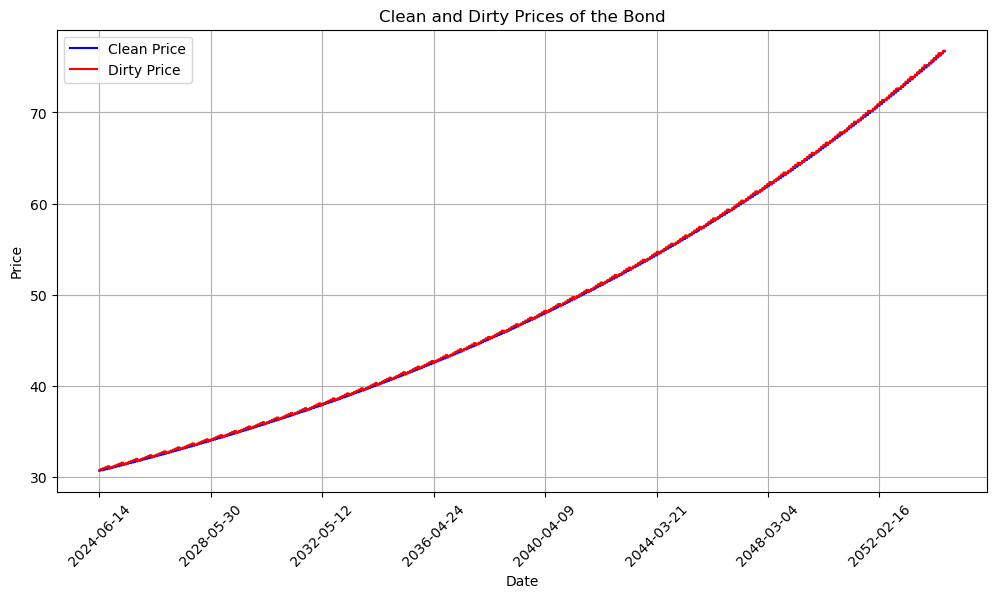

In [28]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Clean Price'], label='Clean Price', color='blue')
plt.plot(df['Date'], df['Dirty Price'], label='Dirty Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Clean and Dirty Prices of the Bond')
plt.legend()
plt.grid(True)

# Rotate x-axis labels and set major locator for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

plt.show()

In [35]:
# Set the trade date
trade_date = ql.Date(14, 6, 2024)
ql.Settings.instance().evaluationDate = trade_date

# Bond parameters
issue_date = ql.Date(20, 5, 2020)
maturity_date = ql.Date(22, 10, 2061)
tenor = ql.Period(ql.Semiannual)
calendar = ql.UnitedKingdom()
business_convention = ql.ModifiedFollowing
day_count = ql.ActualActual(ql.ActualActual.ISMA)
coupon_rate = 0.005
coupons = [coupon_rate]

# Create the schedule
schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar,
                       business_convention, business_convention,
                       ql.DateGeneration.Backward, False)

ex_dividend_days = 7
settlement_days = 1

# Create the fixed rate bond
face_value = 1000
fixed_rate_bond = ql.FixedRateBond(settlement_days, face_value, schedule, coupons, day_count)

# Create a flat yield term structure for discounting
spot_rate = 4.1386479 / 100
flat_term_structure = ql.FlatForward(trade_date, ql.QuoteHandle(ql.SimpleQuote(spot_rate)), day_count)
discount_curve = ql.RelinkableYieldTermStructureHandle(flat_term_structure)

# Create a bond engine with the discount curve
bond_engine = ql.DiscountingBondEngine(discount_curve)
fixed_rate_bond.setPricingEngine(bond_engine)

# Initialize data storage
data = []

# Generate business days for one year from trade date
one_year_later = calendar.advance(trade_date, ql.Period(1, ql.Years), ql.ModifiedFollowing)
current_date = trade_date

while current_date <= one_year_later:
    if calendar.isBusinessDay(current_date):
        ql.Settings.instance().evaluationDate = current_date
        settlement_date = calendar.advance(current_date, ql.Period(settlement_days, ql.Days), business_convention, False)

        # Calculate bond details
        clean_price = fixed_rate_bond.cleanPrice()
        dirty_price = fixed_rate_bond.dirtyPrice()

        # Calculate accrued interest
        previous_date = issue_date
        for payment_date in schedule:
            if payment_date > current_date:
                break
            previous_date = payment_date

        ex_dividend_date = calendar.advance(payment_date, ql.Period(-ex_dividend_days, ql.Days), business_convention, False)

        actual_days = day_count.dayCount(previous_date, payment_date)
        days_accrued = day_count.dayCount(previous_date, current_date)

        if ex_dividend_date <= current_date < payment_date:
            days_accrued = days_accrued - actual_days
            accrued_interest = face_value * coupon_rate / 2 * days_accrued / actual_days
        else:
            accrued_interest = face_value * coupon_rate / 2 * days_accrued / actual_days

        # Store data
        data.append({
            "Date": ql.Date.to_date(current_date).strftime('%Y-%m-%d'),
            "Clean Price": clean_price,
            "Dirty Price": dirty_price,
            "Accrued Interest": accrued_interest,
            "Days Accrued": days_accrued
        })

    current_date = calendar.advance(current_date, ql.Period(1, ql.Days))

# Create DataFrame
df = pd.DataFrame(data)

# Display rows 80 to 100
df.iloc[80:100]


,Date,Clean Price,Dirty Price,Accrued Interest,Days Accrued
80,2024-10-07,30.936060,31.166935,2.295082,168
81,2024-10-08,30.934694,31.166935,2.308743,169
82,2024-10-09,30.933328,31.166935,2.322404,170
83,2024-10-10,30.931962,31.166935,2.336066,171
84,2024-10-11,30.927864,31.166935,-0.150273,-11
85,2024-10-14,30.926497,31.166935,-0.109290,-8
86,2024-10-15,30.925131,31.166935,-0.095628,-7
87,2024-10-16,30.923765,31.166935,-0.081967,-6
88,2024-10-17,30.922399,31.166935,-0.068306,-5
89,2024-10-18,30.918301,31.166935,-0.054645,-4


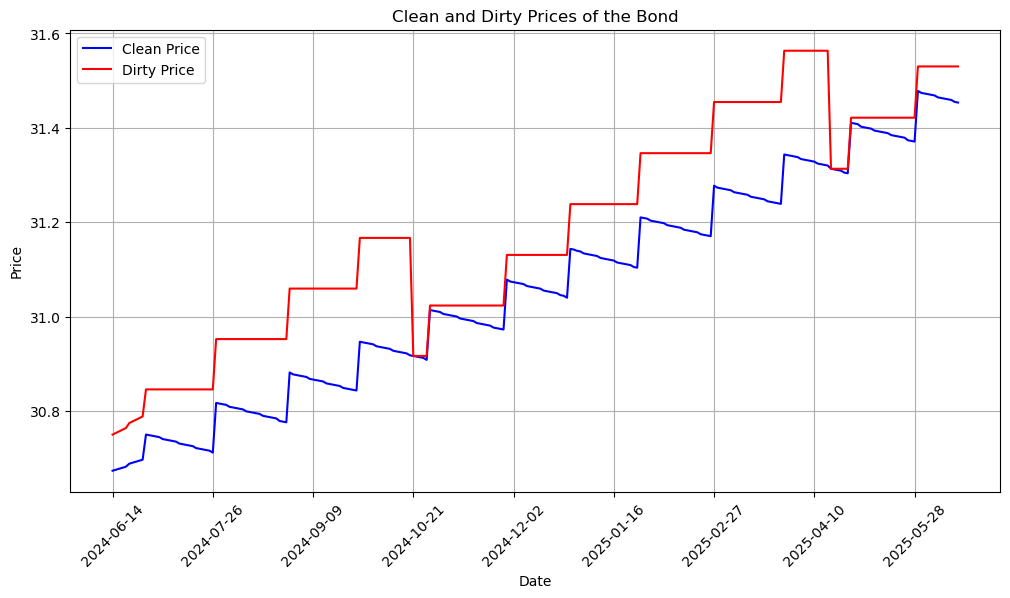

In [36]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Clean Price'], label='Clean Price', color='blue')
plt.plot(df['Date'], df['Dirty Price'], label='Dirty Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Clean and Dirty Prices of the Bond')
plt.legend()
plt.grid(True)

# Rotate x-axis labels and set major locator for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

plt.show()